# Leave-One-Out Validation for Corrected E Data

This notebook documents the leave-one-out validation workflow to address concerns about in-sample bias.

## Overview

The validation process:
1. **Pool phi** from all batches EXCEPT one (e.g., exclude batch 0, pool batches 1-39)
2. **Create checkpoint** with pooled phi
3. **Run predictions** on the excluded batch using that checkpoint
4. **Calculate 10-year AUC** for that batch
5. **Repeat** for all 40 batches
6. **Compare** leave-one-out AUCs to overall pooled AUC

## What This Shows

If leave-one-out AUCs are similar to the overall AUC, this demonstrates:
- Pooling phi is robust (no overfitting to specific batches)
- Model performance is consistent across different subsets of data
- The overall results are reliable and not biased by in-sample evaluation

## Important Note on File Patterns

- **`censor_e_batchrun_vectorized`**: Uses pattern `enrollment_model_W0.0001_batch_*_*.pt` (without "VECTORIZED")
- **`censor_e_batchrun_vectorized_11726`**: Uses pattern `enrollment_model_VECTORIZED_W0.0001_batch_*_*.pt` (with "VECTORIZED")

This validation uses `censor_e_batchrun_vectorized` with the pattern **without** "VECTORIZED".


## Step 1: Create Leave-One-Out Checkpoints

For each batch (0-39), create a checkpoint by pooling phi from all OTHER batches.

**Command to run:**
```bash
cd /Users/sarahurbut/aladynoulli2
for i in {0..39}; do
    python claudefile/create_leave_one_out_checkpoints_correctedE.py --exclude_batch $i
done
```

**Or run individually:**
```bash
python claudefile/create_leave_one_out_checkpoints_correctedE.py --exclude_batch 0
python claudefile/create_leave_one_out_checkpoints_correctedE.py --exclude_batch 1
# ... etc
```

**Output:** Checkpoints saved to:
`/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE_exclude_batch_{N}.pt`

**Note:** This creates 40 checkpoint files (one for each excluded batch).


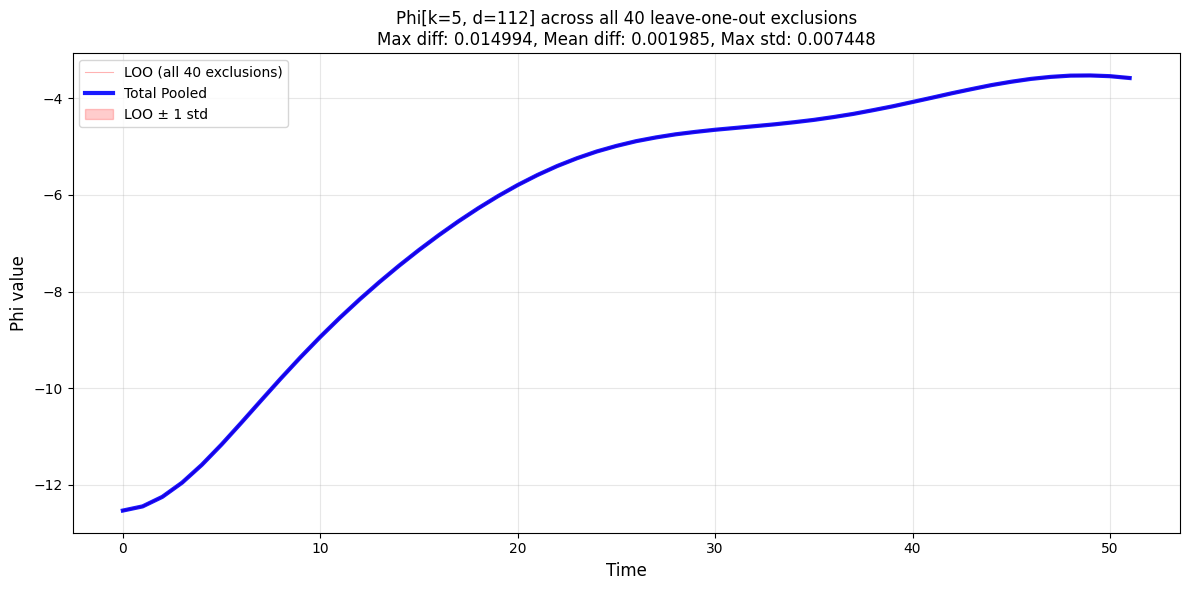


Plotted phi[k=5, d=112] for 40 leave-one-out checkpoints
✓ All 40 leave-one-out exclusions plotted

Statistics across all LOO:
  Max absolute difference: 0.014994
  Mean absolute difference: 0.001985
  Max std across LOO: 0.007448
  Mean std across LOO: 0.002448


In [ ]:
# Plot phi for given (k, d) across all 40 leave-one-out exclusions
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

data_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')

# Parameters: which signature and disease to plot
k = 5  # Signature index (0-20)
d = 112  # Disease index (0-347)

# Load master checkpoint (total pooled)
master_path = data_dir / 'master_for_fitting_pooled_correctedE.pt'
if not master_path.exists():
    print("⚠️  Master checkpoint not found. Create it first or skip this cell.")
else:
    master_ckpt = torch.load(str(master_path), weights_only=False)
    if 'model_state_dict' in master_ckpt and 'phi' in master_ckpt['model_state_dict']:
        phi_master = master_ckpt['model_state_dict']['phi']
    elif 'phi' in master_ckpt:
        phi_master = master_ckpt['phi']
    else:
        phi_master = None
    
    if phi_master is not None:
        if torch.is_tensor(phi_master):
            phi_master = phi_master.detach().cpu().numpy()
        
        K, D, T = phi_master.shape
        
        if k >= K or d >= D:
            print(f"⚠️  Invalid indices: k={k} (max {K-1}), d={d} (max {D-1})")
        else:
            # Load all leave-one-out checkpoints
            loo_checkpoints = sorted(glob.glob(str(data_dir / 'master_for_fitting_pooled_correctedE_exclude_batch_*.pt')))
            
            if len(loo_checkpoints) > 0:
                phi_loo_list = []
                batch_nums = []
                
                for loo_path in loo_checkpoints:
                    try:
                        batch_num = int(Path(loo_path).stem.split('exclude_batch_')[-1])
                        loo_ckpt = torch.load(loo_path, weights_only=False)
                        if 'model_state_dict' in loo_ckpt and 'phi' in loo_ckpt['model_state_dict']:
                            phi_loo = loo_ckpt['model_state_dict']['phi']
                        elif 'phi' in loo_ckpt:
                            phi_loo = loo_ckpt['phi']
                        else:
                            continue
                        
                        if torch.is_tensor(phi_loo):
                            phi_loo = phi_loo.detach().cpu().numpy()
                        
                        phi_loo_list.append(phi_loo[k, d, :])  # Extract just the (k, d) trajectory
                        batch_nums.append(batch_num)
                    except Exception as e:
                        print(f"  Warning: Could not load {Path(loo_path).name}: {e}")
                        continue
                
                if len(phi_loo_list) > 0:
                    # Plot
                    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
                    timepoints = np.arange(T)
                    
                    # Plot all 40 leave-one-out trajectories (one for each excluded batch)
                    for phi_loo_traj, batch_num in zip(phi_loo_list, batch_nums):
                        ax.plot(timepoints, phi_loo_traj, 'r-', linewidth=0.8, alpha=0.3)
                    
                    # Label only once for legend
                    if len(phi_loo_list) > 0:
                        ax.plot([], [], 'r-', linewidth=0.8, alpha=0.3, label=f'LOO (all {len(phi_loo_list)} exclusions)')
                    
                    # Plot total pooled (thicker, more visible)
                    ax.plot(timepoints, phi_master[k, d, :], 'b-', linewidth=3, label='Total Pooled', alpha=0.9)
                    
                    # Calculate statistics
                    phi_loo_array = np.array(phi_loo_list)  # Shape: (n_loo, T)
                    max_diff = np.max(np.abs(phi_loo_array - phi_master[k, d, :]), axis=0)
                    mean_diff = np.mean(np.abs(phi_loo_array - phi_master[k, d, :]), axis=0)
                    std_diff = np.std(phi_loo_array, axis=0)
                    
                    # Plot mean ± std as shaded region
                    ax.fill_between(timepoints, 
                                   phi_master[k, d, :] - std_diff,
                                   phi_master[k, d, :] + std_diff,
                                   alpha=0.2, color='red', label='LOO ± 1 std')
                    
                    ax.set_xlabel('Time', fontsize=12)
                    ax.set_ylabel('Phi value', fontsize=12)
                    ax.set_title(f'Phi[k={k}, d={d}] across all {len(phi_loo_list)} leave-one-out exclusions\n'
                               f'Max diff: {np.max(max_diff):.6f}, Mean diff: {np.mean(mean_diff):.6f}, '
                               f'Max std: {np.max(std_diff):.6f}', fontsize=12)
                    ax.legend(fontsize=10)
                    ax.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\nPlotted phi[k={k}, d={d}] for {len(phi_loo_list)} leave-one-out checkpoints")
                    if len(phi_loo_list) == 40:
                        print("✓ All 40 leave-one-out exclusions plotted")
                    else:
                        print(f"⚠️  Expected 40, found {len(phi_loo_list)}")
                    print(f"\nStatistics across all LOO:")
                    print(f"  Max absolute difference: {np.max(max_diff):.6f}")
                    print(f"  Mean absolute difference: {np.mean(mean_diff):.6f}")
                    print(f"  Max std across LOO: {np.max(std_diff):.6f}")
                    print(f"  Mean std across LOO: {np.mean(std_diff):.6f}")
                else:
                    print("⚠️  Could not load any leave-one-out checkpoints")
            else:
                print("⚠️  No leave-one-out checkpoints found. Create them first.")
    else:
        print("⚠️  Could not extract phi from master checkpoint")


In [ ]:
# Check if checkpoints were created successfully
from pathlib import Path
import glob

data_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
checkpoints = sorted(glob.glob(str(data_dir / 'master_for_fitting_pooled_correctedE_exclude_batch_*.pt')))

print(f"Found {len(checkpoints)} leave-one-out checkpoints")
if len(checkpoints) == 40:
    print("✓ All 40 checkpoints created successfully!")
else:
    print(f"⚠️  Expected 40, found {len(checkpoints)}")
    print("\nMissing batches:")
    created = [int(c.split('exclude_batch_')[-1].split('.')[0]) for c in checkpoints]
    missing = [i for i in range(40) if i not in created]
    print(missing)


Found 40 leave-one-out checkpoints
✓ All 40 checkpoints created successfully!


## Step 2: Run Predictions on Excluded Batches

For each excluded batch, run predictions using its corresponding leave-one-out checkpoint.

**Command to run (all batches):**
```bash
cd /Users/sarahurbut/aladynoulli2
python claudefile/run_leave_one_out_predictions_correctedE.py --skip_completed
```

**Or run in background (recommended, as this takes a while):**
```bash
```

**Or run a single batch for testing:**
```bash
python claudefile/run_leave_one_out_predictions_correctedE.py --batch 0
```

**Output:** Predictions saved to:
`/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_correctedE/batch_{N}/pi_enroll_fixedphi_sex_{start}_{end}.pt`

**Note:** This will take a while (40 batches × prediction time per batch). Each batch processes 10,000 samples.


In [ ]:
# Check if predictions were created successfully
from pathlib import Path
import glob

predictions_base = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_correctedE/')

prediction_files = []
for batch_idx in range(40):
    start_idx = batch_idx * 10000
    end_idx = (batch_idx + 1) * 10000
    pred_file = predictions_base / f'batch_{batch_idx}/pi_enroll_fixedphi_sex_{start_idx}_{end_idx}.pt'
    if pred_file.exists():
        prediction_files.append((batch_idx, pred_file))

print(f"Found {len(prediction_files)} prediction files (out of 40 expected)")
if len(prediction_files) == 40:
    print("✓ All predictions created successfully!")
else:
    print(f"⚠️  Missing predictions for batches:")
    created_batches = [b for b, _ in prediction_files]
    missing = [i for i in range(40) if i not in created_batches]
    print(missing)


Found 40 prediction files (out of 40 expected)
✓ All predictions created successfully!


# Let's compare the predcitions with the earlier (non loo)

%run /Users/sarahurbut/aladynoulli2/claudefile/compare_loo_vs_master_predictions.py --batches 0,1,2 --n_bootstraps 100)

In [ ]:
%run /Users/sarahurbut/aladynoulli2/claudefile/compare_loo_vs_master_predictions.py --batches 0,1,2 --n_bootstraps 10

COMPARING LEAVE-ONE-OUT VS MASTER PREDICTIONS
Batches to check: [0, 1, 2]
Master pi directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_correctedE_vectorized/
Leave-one-out pi directory: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_correctedE/

Loading full data files...
Loaded Y: torch.Size([407878, 348, 52]), E: torch.Size([407878, 348]), pce_df: 400000

BATCH 0: samples 0-10000
Loading master pi: pi_enroll_fixedphi_sex_0_10000.pt
Loading leave-one-out pi: pi_enroll_fixedphi_sex_0_10000.pt
Master pi shape: torch.Size([10000, 348, 52])
Leave-one-out pi shape: torch.Size([10000, 348, 52])

--------------------------------------------------------------------------------
CORRELATION ANALYSIS
--------------------------------------------------------------------------------
Overall correlation: r = 0.994904, p = 0.00e+00

Per-disease correlations (top 10):
  Pyelonephritis                : r = 0.999700
  Other d

# now do all!

In [ ]:
# run in a terminal

# python /Users/sarahurbut/aladynoulli2/claudefile/pool_loo_pis_and_evaluate.py --n_bootstraps 100 --skip_pooling

## Step 3: Calculate 10-Year AUC

Calculate 10-year AUC for each excluded batch. We have two options:

### Option A: Per-Batch AUC (Recommended)

Calculates AUC separately for each batch. This allows you to see variability across batches.

**Command:**
```bash
cd /Users/sarahurbut/aladynoulli2
python /Users/sarahurbut/aladynoulli2/claudefile/pool_loo_pis_and_evaluate.py --n_bootstraps 100 --skip_pooling
```
# output 
/Users/sarahurbut/aladynoulli2/claudefile/loo_vs_master_pooled_comparison.csv

## Step 4: Compare Results

Compare leave-one-out AUCs to overall pooled AUC and generate summary statistics.

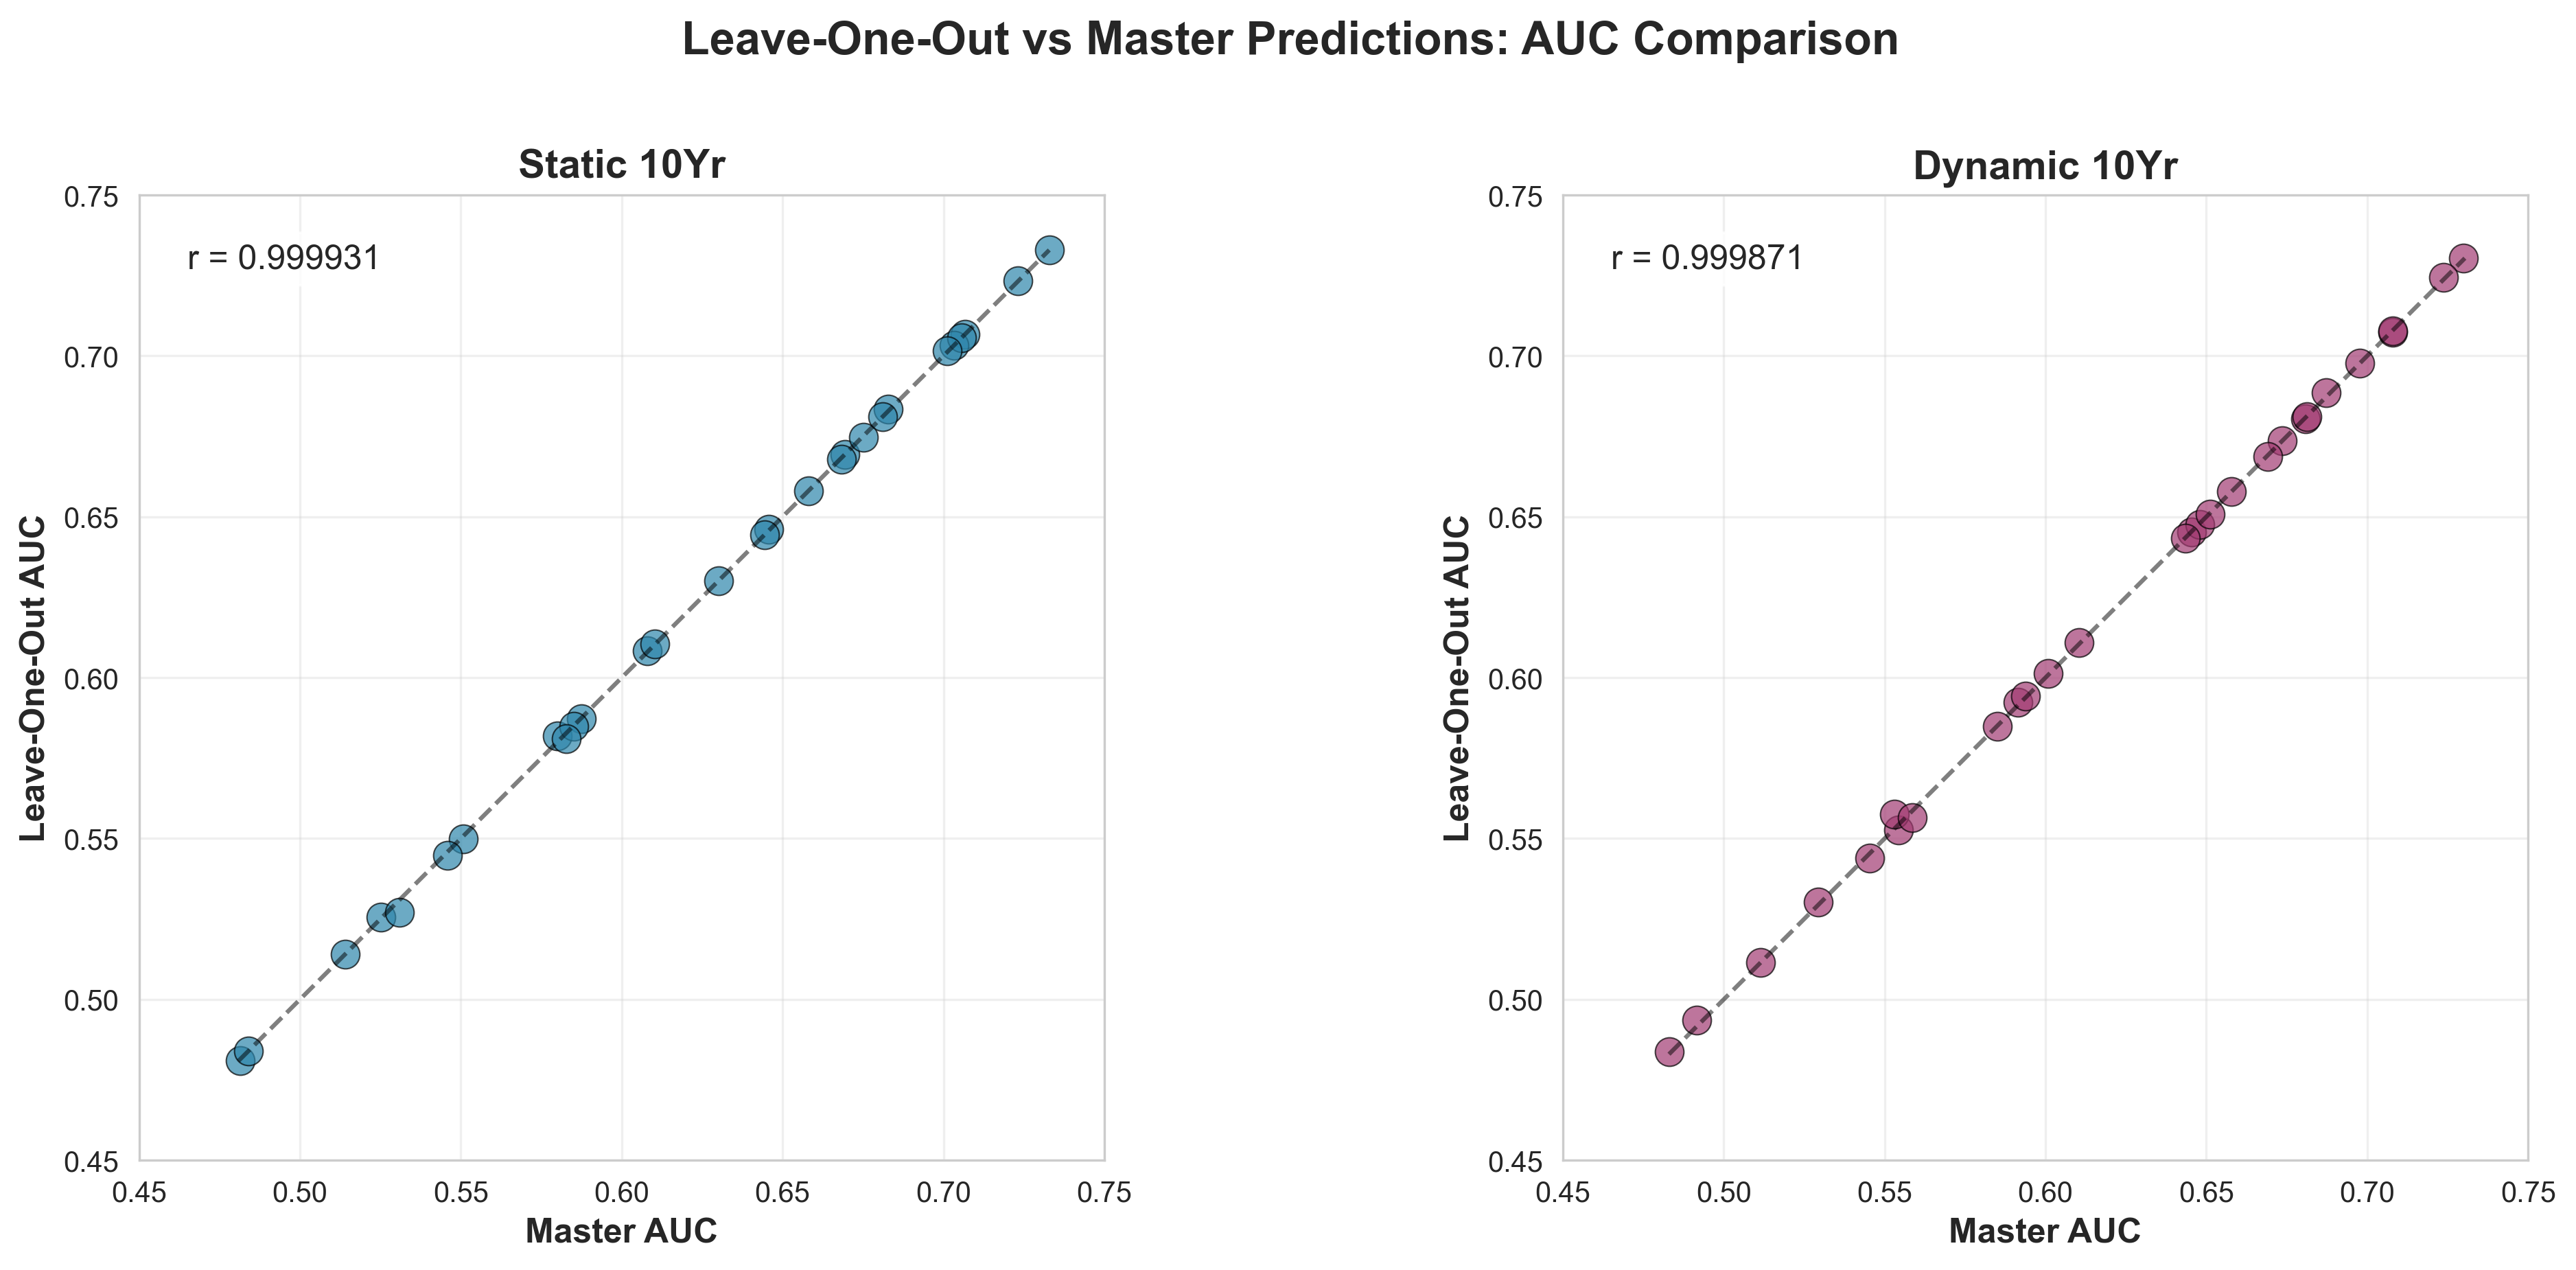

SUMMARY STATISTICS

Static 10Yr:
  Mean |difference|: 0.000499
  Median |difference|: 0.000228
  Max |difference|: 0.003772
  Correlation: 0.999931
  |diff| < 0.001: 24 / 28 (85.7%)
  |diff| < 0.005: 28 / 28 (100.0%)

Dynamic 10Yr:
  Mean |difference|: 0.000756
  Median |difference|: 0.000463
  Max |difference|: 0.004473
  Correlation: 0.999871
  |diff| < 0.001: 22 / 28 (78.6%)
  |diff| < 0.005: 28 / 28 (100.0%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data
df = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/loo_vs_master_pooled_comparison.csv')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color palette
colors = {'static_10yr': '#2E86AB', 'dynamic_10yr': '#A23B72'}

for idx, horizon in enumerate(['static_10yr', 'dynamic_10yr']):
    ax = axes[idx]
    data = df[df['horizon'] == horizon]
    
    # Scatter plot
    ax.scatter(data['master_auc'], data['loo_auc'], 
               alpha=0.7, s=100, c=colors[horizon], 
               edgecolors='black', linewidth=0.5, label=horizon.replace('_', ' ').title())
    
    # Perfect agreement line (y=x)
    min_val = min(data[['master_auc', 'loo_auc']].min())
    max_val = max(data[['master_auc', 'loo_auc']].max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'k--', linewidth=1.5, alpha=0.5, label='Perfect agreement')
    
    # Calculate correlation
    corr = data['master_auc'].corr(data['loo_auc'])
    
    # Add correlation text
    ax.text(0.05, 0.95, f'r = {corr:.6f}', 
            transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8))
    
    # Labels and title
    ax.set_xlabel('Master AUC', fontsize=12, fontweight='bold')
    ax.set_ylabel('Leave-One-Out AUC', fontsize=12, fontweight='bold')
    ax.set_title(f'{horizon.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    # Set same limits for both axes
    ax.set_xlim([0.45, 0.75])
    ax.set_ylim([0.45, 0.75])
    
    # Add minor ticks
    ax.minorticks_on()

# Overall title
fig.suptitle('Leave-One-Out vs Master Predictions: AUC Comparison', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/loo_vs_master_auc_comparison.png', 
            bbox_inches='tight', facecolor='white')
plt.show()

# Print summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
for horizon in ['static_10yr', 'dynamic_10yr']:
    data = df[df['horizon'] == horizon]
    abs_diffs = data['difference'].abs()
    print(f"\n{horizon.replace('_', ' ').title()}:")
    print(f"  Mean |difference|: {abs_diffs.mean():.6f}")
    print(f"  Median |difference|: {abs_diffs.median():.6f}")
    print(f"  Max |difference|: {abs_diffs.max():.6f}")
    print(f"  Correlation: {data['master_auc'].corr(data['loo_auc']):.6f}")
    print(f"  |diff| < 0.001: {sum(abs_diffs < 0.001)} / {len(abs_diffs)} ({100*sum(abs_diffs < 0.001)/len(abs_diffs):.1f}%)")
    print(f"  |diff| < 0.005: {sum(abs_diffs < 0.005)} / {len(abs_diffs)} ({100*sum(abs_diffs < 0.005)/len(abs_diffs):.1f}%)")

## Interpretation

### What Good Results Look Like

If the leave-one-out validation is successful:
- **AUCs should be similar** across batches (low coefficient of variation, e.g., CV < 0.05)
- **AUC range** (max - min) should be small (e.g., < 0.05 for most diseases)
- **Mean leave-one-out AUC** should be similar to overall pooled AUC

### What This Demonstrates

If AUCs are consistent across batches:
- ✅ Pooling phi is robust (no overfitting to specific batches)
- ✅ Model performance is consistent across different subsets of data
- ✅ The overall results are reliable and not biased by in-sample evaluation

### Comparison to Overall Results

You can compare the mean leave-one-out AUCs to the overall pooled AUC from the performance notebook. They should be very similar if the model is robust.


## Quick Reference: All Commands

```bash
# Step 1: Create all 40 leave-one-out checkpoints
cd /Users/sarahurbut/aladynoulli2
for i in {0..39}; do
    python claudefile/create_leave_one_out_checkpoints_correctedE.py --exclude_batch $i
done

# Step 2: Run predictions (optimized version, skips completed batches)
nohup python claudefile/run_leave_one_out_predictions_optimized_correctedE.py --skip_completed > loo_predictions_optimized.log 2>&1 &

# Step 3: Calculate AUC (Option A: per-batch)
python claudefile/calculate_leave_one_out_auc_correctedE.py --all_batches

# Step 3 (Alternative): Calculate AUC (Option B: pooled)
python claudefile/calculate_leave_one_out_auc_pooled_correctedE.py

# Step 4: Compare results
python claudefile/compare_leave_one_out_auc_correctedE.py
```

## File Locations

- **Checkpoints:** `/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE_exclude_batch_{N}.pt`
- **Predictions:** `/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_correctedE/batch_{N}/pi_enroll_fixedphi_sex_{start}_{end}.pt`
- **AUC Results (Option A):** `/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_auc_results_correctedE.csv`
- **AUC Results (Option B):** `/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_auc_pooled_correctedE.csv`
- **Comparison:** `/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/leave_one_out_comparison_correctedE.csv`
